[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)

# based on Fig 2. in [Fisher 1991](https://doi.org/10.1034/j.1600-0889.1991.t01-4-00006.x)
Deuterium excess $d=\delta(D) - 8\delta( ^{18}O)$

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.physics.constants import PER_CENT, PER_MILLE, in_unit


In [3]:
formulae = Formulae(
        drop_growth='Mason1971',
        diffusion_thermics='Neglect',
        latent_heat_vapourisation='Constant',
        saturation_vapour_pressure='Lowe1977',
        isotope_meteoric_water_line="Dansgaard1964",
        isotope_diffusivity_ratios="Stewart1975",
        isotope_equilibrium_fractionation_factors="VanHook1968",
        isotope_kinetic_fractionation_factors="BolotEtAl2013"
)
const=formulae.constants

In [9]:
temperature = np.linspace(223.15, 263.15, 10) * si.K
saturation = 0.9
D = formulae.diffusion_thermics.D(1,1)
K = formulae.diffusion_thermics.K(1,1)
pvs = formulae.saturation_vapour_pressure.pvs_ice(temperature)
r_dr_dt = formulae.drop_growth.r_dr_dt(
    RH_eq=0,
    T=temperature,
    RH=saturation,
    lv=formulae.latent_heat_vapourisation.lv(temperature),
    pvs=pvs,
    D=D,
    K=K
)

molar_mass_isotopes = {
    '2H': const.M_1H + const.M_2H + const.M_16O,
    '18O': 2 * const.M_1H + const.M_18O
}

In [10]:
alpha_l = alpha_kinetic = alpha_kinetic_eff = {}
for isotope, molar_mass in molar_mass_isotopes.items():
    alpha_l[isotope] = getattr(formulae.isotope_equilibrium_fractionation_factors, f'alpha_l_{isotope}')(temperature)
    diffusivity_ratio = getattr(formulae.isotope_diffusivity_ratios, f'ratio_{isotope}')(temperature)
    A_liquid_to_ice = formulae.isotope_kinetic_fractionation_factors.transfer_coefficient_liq_to_ice(
        diffusion_ventilation_coefficient=D,
        condensed_water_density=1,
        pvs=pvs,
        molar_mass=molar_mass,
        temperature=temperature,
        relative_humidity=saturation,
        r_dr_dt_assuming_RHeq0=r_dr_dt,
    )
    effective_saturation = formulae.isotope_kinetic_fractionation_factors.effective_supersaturation(
        transfer_coefficient_liq_to_ice=A_liquid_to_ice,
        relative_humidity=saturation
    )
    print(effective_saturation)
    alpha_kinetic_eff[isotope] = formulae.isotope_kinetic_fractionation_factors.alpha_kinetic(
        alpha_equilibrium=alpha_l[isotope],
        relative_humidity=effective_saturation,
        heavy_to_light_diffusivity_ratio=diffusivity_ratio
    )
    alpha_kinetic[isotope] = formulae.isotope_kinetic_fractionation_factors.alpha_kinetic(
        alpha_equilibrium=alpha_l[isotope],
        relative_humidity=saturation,
        heavy_to_light_diffusivity_ratio=diffusivity_ratio
    )

[0.0083754  0.00832899 0.0082578  0.00815325 0.00800334 0.00779458
 0.00751373 0.0071501  0.00669866 0.00616344]
[0.00796112 0.00791698 0.00784929 0.00774987 0.00760732 0.00740881
 0.00714176 0.00679601 0.00636679 0.00585793]


In [11]:
def delta(delta_0, alpha, alpha_0, m, m_0):
    return (
            (1 + delta_0)
            * alpha / alpha_0
            * m / m_0
            * np.exp(alpha - 1)
            -1
    )

In [12]:
delta_18O_0 = 15 * PER_MILLE
delta_2H_0 = 8 * delta_18O_0
T_0 = (- 15 + 273.15) * si.K
delta_18O = delta(
    delta_0=delta_18O_0,
    alpha=alpha_l['18O']*alpha_kinetic['18O'],
    alpha_0=1,
    m=1,
    m_0=1
)
delta_2H = delta(
    delta_0=delta_2H_0,
    alpha=alpha_l['2H']*alpha_kinetic['2H'],
    alpha_0=1,
    m=1,
    m_0=1
)
d_excess_eff = formulae.isotope_meteoric_water_line.excess_d(
    delta_2H=delta_2H,
    delta_18O=delta_18O,
)
d_excess = formulae.isotope_meteoric_water_line.excess_d(
    delta_2H=delta_2H,
    delta_18O=delta_18O,
)

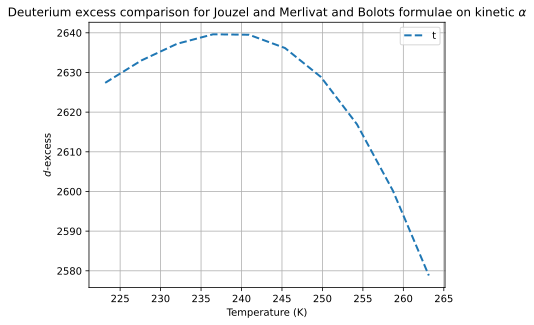

In [13]:
fig, ax = plt.subplots()
#ax.plot(temperature, in_unit(d_excess_eff, PER_MILLE), label="effective")
ax.plot(temperature, in_unit(d_excess, PER_MILLE), '--', linewidth=2, label="t")
ax.set_xlabel("Temperature (K)")
ax.set_ylabel(r"$d$-excess [per mille]")
ax.set_title("Deuterium excess comparison for Jouzel and Merlivat and Bolots formulae on kinetic $\\alpha$")
ax.legend()
ax.grid()
show_plot("deuterium_excess")